# LAB 2 MOS: Modelo Avanzado

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Problema 1: Distribucion optima de recursos en una mision humanitaria

### Preprocesamiento de datos

Los recursos se miden por toneladas para el peso. Se pasara a kilogramos para manejar correctamente el fraccionamiento de estos.
Para manejar los equipo medicos, se definira por cantidad de fracciones posibles. Solo se puede cargar 300kg juntos, no es mas divisible que eso. Por lo tanto, hay 66 unidades de equipo medico (se ignora el resto, que son 200kg y no se pueden enviar por si solos)

In [107]:
from pyomo.environ import *
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np

t = 1000
recursos = {
    'Alimentos': {'valor': 50, 'peso': 15*t, 'volumen': 8},
    'Medicinas': {'valor': 100, 'peso': 5*t, 'volumen': 2},
    'Agua': {'valor': 60, 'peso': 18*t, 'volumen': 12},
    'Mantas': {'valor': 40, 'peso': 10*t, 'volumen': 6}
}
equipo = {'valor': 120, 'unidades': 66, 'volumen': 8}
aviones = {
    'A1': {'peso_max': 30*t, 'volumen_max': 25},
    'A2': {'peso_max': 42*t, 'volumen_max': 30},
    'A3': {'peso_max': 50*t, 'volumen_max': 35},
    
}

### Definicion del modelo matematico

#### Conjuntos

Recursos: $$ R = \{R1,R_2,R_3,R_4\}$$
$$ \forall i \in R$$
Recurso equipo medico: $$ E = \{E_1\}$$

Aviones: $$ A = \{A_1,A_2,A_3\}$$
$$ \forall j \in A$$

#### Parametros
Aviones:
Capacidad en kg de cada avion
$$ W_j: \forall j \in A$$
Capacidad en m^3 de cada avion
$$ V_j: \forall j \in A$$

Recursos:
peso disponible de cada recurso 
$$ w_i: \forall i \in R$$
volumen disponible de cada recurso 
$$ v_i: \forall i \in R$$
valor de cada recurso
$$ val_i: \forall i \in R$$

Equipo medico:

U: unidades de equipo medico disponible para transportar

V_e: Valor de transportar el equipo medico

#### Variables de decision

Kilogramos de recurso i que viajan en el avion j
$$ x_{ij} \ge 0 \in N$$

Unidades de equipos medico que viajan en el avion j
$$ y_{j} \ge 0 \in N$$

Valor que indica si el avión j lleva equipo medico
$$ z_{j} \in {0,1} $$

#### Funcion objetivo

$$ MAX(\sum_{i\in R} \sum_{j\in A} x_{ij} \cdot val_i / w_i + \sum_{j\in A} y{j} * V_e / U)$$

La fracción de valor que se transporta de cada recurso en cada avion (se maximiza)

#### Restricciones

Disponibilidad de cada recurso: No se mandan mas kilogramos de los que se tienen de cada recurso, ni mas unidades de equipo medico

$$ \sum_{j\in A} x_{ij} \leq w_i \ , \forall i \in R$$
$$ \sum_{j\in A}y_{j} \leq U \$$

Capacidad de los aviones: Tanto en peso como volumen

$$ (\sum_{i\in R} x_{ij}) + y_{j} \cdot 300 \leq W_j , \forall j \in A$$
$$ (\sum_{i\in R} x_{ij} \cdot v_i / w_i) + (y_{j}/U) * 10   \leq V_j , \forall j \in A$$

No medicinas en avion 1:

$$ x_{2,1} = 0 $$

Incompatibilidad de agua y equipo medicos:

$$ x_{3,j} \leq (1-z_{j}) \cdot W_j , \forall j \in A $$

Presencia de equipo medico

$$ y_{j} \leq U \cdot z_{j} , \forall j \in A $$

#### Tipo de problema


### Codigo en pyomo

In [108]:
model = ConcreteModel()

# Conjuntos y parametros

model.R = Set(initialize=['Alimentos', 'Medicinas', 'Agua', 'Mantas'])
model.A = Set(initialize=['A1', 'A2', 'A3'])

# Variables de decision

model.x = Var(model.R, model.A, domain=NonNegativeIntegers)
model.y = Var(model.A, domain=NonNegativeIntegers)
model.z = Var(model.A, domain=Binary)

# Funcion objetivo

def obj_rule(model):
    return sum(model.x[i, j] * recursos[i]['valor'] / recursos[i]['peso'] for i in model.R for j in model.A) + \
           sum(model.y[j] * equipo['valor'] / equipo['unidades'] for j in model.A)

model.obj = Objective(rule=obj_rule, sense=maximize)

# Restricciones

model.restriccion_disponibilidad = ConstraintList()
for i in model.R:
    model.restriccion_disponibilidad.add(
        sum(model.x[i, j] for j in model.A) <= recursos[i]['peso']
    )
model.restriccion_disponibilidad_e = Constraint(expr=sum(model.y[j] for j in model.A) <= 66)

model.restriccion_peso = ConstraintList()
for j in model.A:
    model.restriccion_peso.add(
        sum(model.x[i, j] for i in model.R) + model.y[j]*300 <= aviones[j]['peso_max']
    )

model.restriccion_volumen = ConstraintList()
for j in model.A:
    model.restriccion_volumen.add(
        sum(model.x[i, j] * recursos[i]['volumen']/recursos[i]['peso'] for i in model.R) + (model.y[j]/66)*10 <= aviones[j]['volumen_max']
    )

model.restriccion_compatibilidad = Constraint(expr=model.x['Medicinas', 'A1'] == 0)

model.restriccion_incompatibilidad = ConstraintList()
for j in model.A:
    model.restriccion_incompatibilidad.add(
        model.x["Agua",j] <= (1 - model.z[j]) * aviones[j]["peso_max"]
    )

model.presencia_equipo = ConstraintList()
for j in model.A:
    model.presencia_equipo.add(
        model.y[j] <= equipo["unidades"] * model.z[j]
    ) 

# Solucionarlo
solver = SolverFactory('glpk')
solver.solve(model)
print(model.obj())

370.0


In [109]:
asignacion_aviones = {j: {'Recursos': [], 'Peso Usado': 0, 'Volumen Usado': 0} for j in model.A}

# Recopilar los resultados
for i in model.R:
    for j in model.A:
        if model.x[i, j].value > 0:
            asignacion_aviones[j]['Recursos'].append(i)
            asignacion_aviones[j]['Peso Usado'] += model.x[i, j].value
            asignacion_aviones[j]['Volumen Usado'] += model.x[i, j].value * recursos[i]['volumen'] / recursos[i]['peso']

# Incluir equipo médico en la asignación
for j in model.A:
    if model.y[j].value > 0:
        asignacion_aviones[j]['Recursos'].append('Equipo Médico')
        asignacion_aviones[j]['Peso Usado'] += model.y[j].value * 300
        asignacion_aviones[j]['Volumen Usado'] += model.y[j].value * equipo['volumen'] / equipo['unidades']


In [110]:
# Mostrar la asignación de recursos por avión
table_data = []
for j in model.A:
    row = [j, 
           ', '.join(asignacion_aviones[j]['Recursos']), 
           asignacion_aviones[j]['Peso Usado'], 
           asignacion_aviones[j]['Volumen Usado']]
    table_data.append(row)

headers = ["Avión", "Recursos Asignados", "Peso Usado (kg)", "Volumen Usado (m^3)"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+---------+----------------------------------+-------------------+-----------------------+
| Avión   | Recursos Asignados               |   Peso Usado (kg) |   Volumen Usado (m^3) |
+=========+==================================+===================+=======================+
| A1      | Alimentos, Mantas, Equipo Médico |             30000 |               14.1067 |
+---------+----------------------------------+-------------------+-----------------------+
| A2      | Alimentos, Medicinas, Agua       |             37800 |               21.8933 |
+---------+----------------------------------+-------------------+-----------------------+
| A3      |                                  |                 0 |                0      |
+---------+----------------------------------+-------------------+-----------------------+


In [111]:
# Mostrar la asignación de recursos individuales por avión
tabla_peso_enviado = []

recursos_lista = list(model.R) + ["Equipo Médico"]
for i in recursos_lista: 
    fila = [i] 
    cantidad_avion1 = 0
    cantidad_avion2 = 0

    for j in model.A:
        if i == 'Equipo Médico':  # Para el equipo médico
            cantidad = model.y[j].value * 300
        else:  # Para los demás recursos
            cantidad = model.x[i, j].value

        if j == 'A1':
            cantidad_avion1 = cantidad
        elif j == 'A2':
            cantidad_avion2 = cantidad

    fila.append(cantidad_avion1)  # Añadimos la cantidad de Avión A a la fila
    fila.append(cantidad_avion2)

    tabla_peso_enviado.append(fila)  # Añadimos la fila a la tabla

# Mostrar la tabla con tabulate
headers = ["Recurso", "Avión 1", "Avión 2"]
print(tabulate(tabla_peso_enviado, headers=headers, tablefmt="grid"))

+---------------+-----------+-----------+
| Recurso       |   Avión 1 |   Avión 2 |
+===============+===========+===========+
| Alimentos     |       200 |     14800 |
+---------------+-----------+-----------+
| Medicinas     |         0 |      5000 |
+---------------+-----------+-----------+
| Agua          |         0 |     18000 |
+---------------+-----------+-----------+
| Mantas        |     10000 |         0 |
+---------------+-----------+-----------+
| Equipo Médico |     19800 |         0 |
+---------------+-----------+-----------+


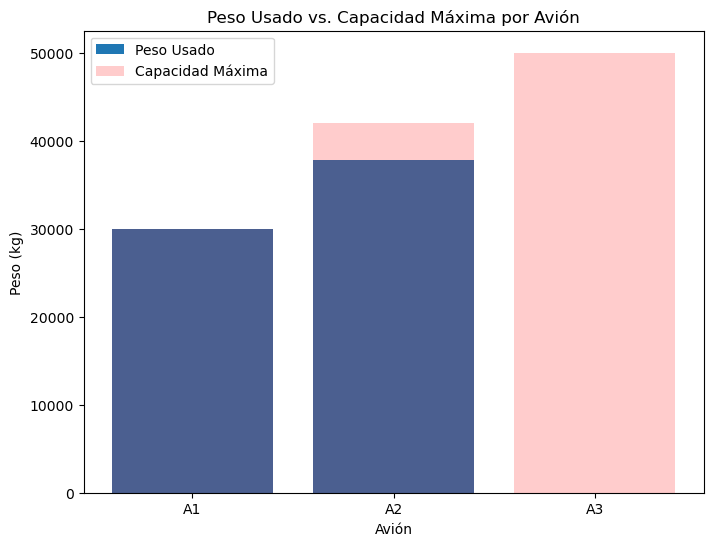

In [112]:
# Datos para la gráfica de peso
aviones_lista = ['A1','A2','A3']
peso_max=[30000,42000,50000]
peso_usado = [asignacion_aviones[j]['Peso Usado'] for j in aviones_lista]


# Crear la gráfica de peso
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(aviones_lista, peso_usado, label='Peso Usado')
ax.bar(aviones_lista, peso_max, alpha=0.2, label='Capacidad Máxima', color='red')

ax.set_xlabel('Avión')
ax.set_ylabel('Peso (kg)')
ax.set_title('Peso Usado vs. Capacidad Máxima por Avión')
ax.legend()
plt.show()

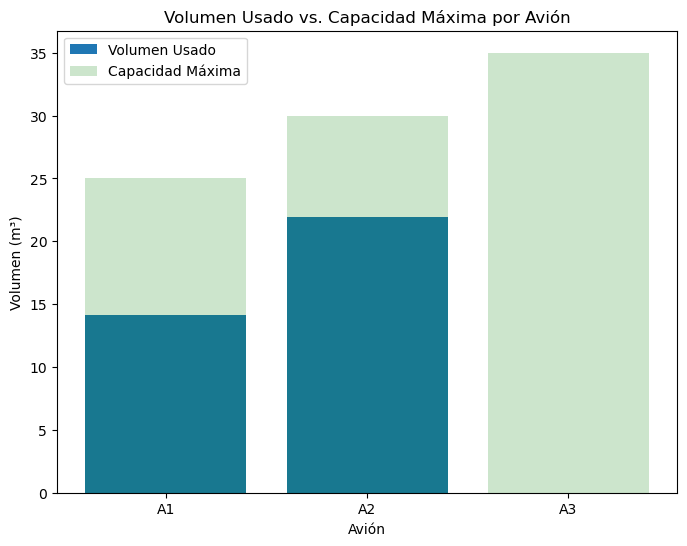

In [113]:
# Datos para la gráfica de volumen
volumen_usado = [asignacion_aviones[j]['Volumen Usado'] for j in aviones_lista]
volumen_max = [25,30,35]

# Crear la gráfica de volumen
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(aviones_lista, volumen_usado, label='Volumen Usado')
ax.bar(aviones_lista, volumen_max, alpha=0.2, label='Capacidad Máxima', color='green')

ax.set_xlabel('Avión')
ax.set_ylabel('Volumen (m³)')
ax.set_title('Volumen Usado vs. Capacidad Máxima por Avión')
ax.legend()
plt.show()

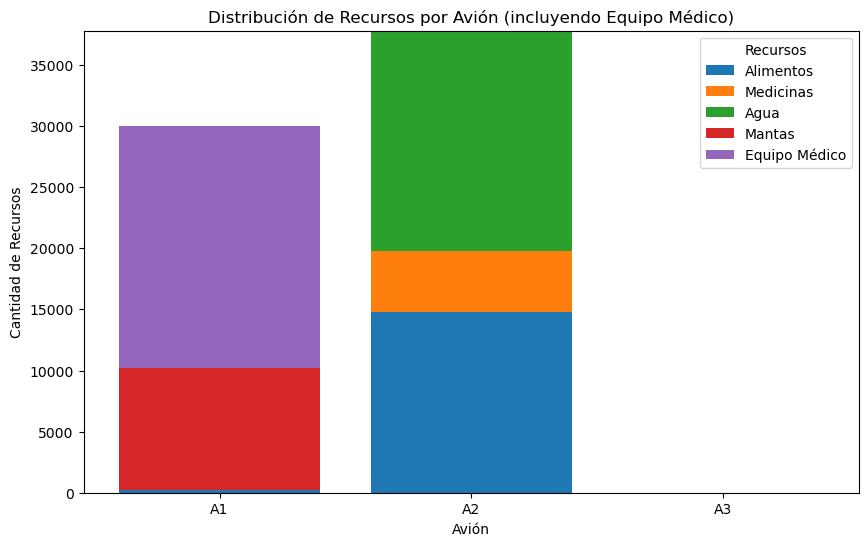

In [114]:
# Datos para la gráfica de distribución de recursos, incluyendo equipo médico
asignaciones = np.zeros((len(aviones_lista), len(recursos_lista)))

# Llenamos la matriz con las asignaciones de recursos
for i, recurso in enumerate(recursos_lista[:-1]):  # Para los recursos
    for j, avion in enumerate(aviones_lista):
        asignaciones[j, i] = model.x[recurso, avion].value
#Para el equipo medico
for j, avion in enumerate(aviones_lista):
    asignaciones[j, -1] = model.y[avion].value * 300

# Crear la gráfica de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(aviones_lista, asignaciones[:, 0], label=recursos_lista[0])
for i in range(1, len(recursos_lista)):
    ax.bar(aviones_lista, asignaciones[:, i], bottom=np.sum(asignaciones[:, :i], axis=1), label=recursos_lista[i])

ax.set_xlabel('Avión')
ax.set_ylabel('Cantidad de Recursos')
ax.set_title('Distribución de Recursos por Avión (incluyendo Equipo Médico)')
ax.legend(title='Recursos')
plt.show()


### Analisis

Al poder dividir en fracciones los recursos (kg), ya no se requiere del tercer avión para enviar todos los recursos.

Aun se pueden enviar todos (obteniendo el valor de 370 como antes) y solo en dos aviones que no se llenan por completo entre ambos (tanto en volumen como en peso)

Aunque los aviones están casi llenos en términos de peso, hay espacio disponible en volumen que podría aprovecharse mejor

## Problema 2: Redes de transporte

### Definicion del modelo matematico

#### Conjuntos

Origen: $$ O = \{O1,O_2\}$$
$$ \forall j \in O$$

Destinos: $$ D = \{D_1,D_2,D_3,D_4,D_5,D_6\}$$
$$ \forall i \in D$$

#### Parametros
Origen:
Oferta en toneladas
$$ o_j: \forall j \in O$$

Destino:
demanda en toneladas 
$$ d_i: \forall i \in D$$

Costos:
$$ c_{ij}: \forall i\in D, \forall j\in O$$

#### Variables de decision

Toneladas a enviar de desde ciudad j a ciudad i
$$ x_{ij} \in N$$


#### Funcion objetivo

$$ MIN(\sum_{i\in D} \sum_{j\in O} x_{ij} \cdot c_{ij})$$

Valor de transportar en total (se minimiza)

#### Restricciones

Disponibilidad de cada origen: No se mandan mas toneladas de las que se tienen en bodega

$$ \sum_{i\in D} x_{ij} \leq o_j \ , \forall j \in O$$

Demanda de cada destino: Se manda exactamente la cantidad que se pide

$$ \sum_{j\in O} x_{ij} = d_i , \forall i \in D$$

Restricciones especificas:

$$ x_{1,1} = 0 $$

$$ x_{2,2} = 0 $$

No se envia de Bogota a Cali ni de Medellin a Barranquilla

$$ x_{ij} \ge 0 $$


#### Tipo de problema
LP


### Codigo en pyomo

In [115]:

destino = {
    'Cali': {'Bogota': 0, 'Medellin': 2.5, 'demanda': 125},
    'Barranquilla': {'Bogota': 2.5, 'Medellin': 0, 'demanda': 175},
    'Pasto': {'Bogota': 1.6, 'Medellin': 2.0, 'demanda': 225},
    'Tunja': {'Bogota': 1.4, 'Medellin': 1.0, 'demanda': 250},
    'Chia': {'Bogota': 0.8, 'Medellin': 1.0, 'demanda': 225},
    'Manizales': {'Bogota': 1.4, 'Medellin': 0.8, 'demanda': 200}
}
origen = {
    'Bogota': {'oferta': 550},
    'Medellin': {'oferta': 700}   
}

In [116]:
model2 = ConcreteModel()

# Conjuntos y parámetros
O = ['Bogota', 'Medellin']
D = ['Cali', 'Barranquilla', 'Pasto', 'Tunja', 'Chia', 'Manizales']
model2.O = origen.keys()
model2.D = destino.keys()

# Variables de decisión
model2.x = Var(model2.O, model2.D, domain=NonNegativeIntegers)

# Función objetivo
def objective_rule(model):
    return sum(model.x[j, i] * destino[i][j] for j in model.O for i in model.D)
model2.obj = Objective(rule=objective_rule, sense='minimize')

# Restricciones
def disponibilidad_rule(model, j):
    return sum(model.x[j, i] for i in model.D) <= origen[j]['oferta']
model2.disponibilidad = Constraint(model2.O, rule=disponibilidad_rule)

def demanda_rule(model, i):
    return sum(model.x[j, i] for j in model.O) == destino[i]['demanda']
model2.demanda = Constraint(model2.D, rule=demanda_rule)

model2.no_bogota_cali = Constraint(expr=model2.x['Bogota', 'Cali'] == 0)
model2.no_medellin_barranquilla = Constraint(expr=model2.x['Medellin', 'Barranquilla'] == 0)

# Resolver el modelo
solver = SolverFactory('glpk')
solver.solve(model2)

print(model2.obj())

1715.0


### Resultados y analisis

In [117]:
# Tabla de envios
data_enviado = [
    ['Cali', model2.x['Bogota', 'Cali'].value, model2.x['Medellin', 'Cali'].value],
    ['Barranquilla', model2.x['Bogota', 'Barranquilla'].value, model2.x['Medellin', 'Barranquilla'].value],
    ['Pasto', model2.x['Bogota', 'Pasto'].value, model2.x['Medellin', 'Pasto'].value],
    ['Tunja', model2.x['Bogota', 'Tunja'].value, model2.x['Medellin', 'Tunja'].value],
    ['Chia', model2.x['Bogota', 'Chia'].value, model2.x['Medellin', 'Chia'].value],
    ['Manizales', model2.x['Bogota', 'Manizales'].value, model2.x['Medellin', 'Manizales'].value]
]

total_bogota = sum(row[1] for row in data_enviado)
total_medellin = sum(row[2] for row in data_enviado)

data_enviado.append(['Totales', total_bogota, total_medellin])

headers = ['Destino', 'Bogota', 'Medellin']
table = tabulate(data_enviado, headers, tablefmt='grid')

print(table)

+--------------+----------+------------+
| Destino      |   Bogota |   Medellin |
+==============+==========+============+
| Cali         |        0 |        125 |
+--------------+----------+------------+
| Barranquilla |      175 |          0 |
+--------------+----------+------------+
| Pasto        |      225 |          0 |
+--------------+----------+------------+
| Tunja        |        0 |        250 |
+--------------+----------+------------+
| Chia         |      150 |         75 |
+--------------+----------+------------+
| Manizales    |        0 |        200 |
+--------------+----------+------------+
| Totales      |      550 |        650 |
+--------------+----------+------------+


In [118]:
# Cambio de oferta por 50 toneladas
origen = {
    'Bogota': {'oferta': 600},
    'Medellin': {'oferta': 650}   
}

# Resolver el modelo con cambio de ofertas
solver = SolverFactory('glpk')
solver.solve(model2)

# Tomar los datos para la tabla
data_enviado = [
    ['Cali', model2.x['Bogota', 'Cali'].value, model2.x['Medellin', 'Cali'].value],
    ['Barranquilla', model2.x['Bogota', 'Barranquilla'].value, model2.x['Medellin', 'Barranquilla'].value],
    ['Pasto', model2.x['Bogota', 'Pasto'].value, model2.x['Medellin', 'Pasto'].value],
    ['Tunja', model2.x['Bogota', 'Tunja'].value, model2.x['Medellin', 'Tunja'].value],
    ['Chia', model2.x['Bogota', 'Chia'].value, model2.x['Medellin', 'Chia'].value],
    ['Manizales', model2.x['Bogota', 'Manizales'].value, model2.x['Medellin', 'Manizales'].value]
]

total_bogota = sum(row[1] for row in data_enviado)
total_medellin = sum(row[2] for row in data_enviado)

data_enviado.append(['Totales', total_bogota, total_medellin])

headers = ['Destino', 'Bogota', 'Medellin']
table = tabulate(data_enviado, headers, tablefmt='grid')

print(table)

+--------------+----------+------------+
| Destino      |   Bogota |   Medellin |
+==============+==========+============+
| Cali         |        0 |        125 |
+--------------+----------+------------+
| Barranquilla |      175 |          0 |
+--------------+----------+------------+
| Pasto        |      225 |          0 |
+--------------+----------+------------+
| Tunja        |        0 |        250 |
+--------------+----------+------------+
| Chia         |      150 |         75 |
+--------------+----------+------------+
| Manizales    |        0 |        200 |
+--------------+----------+------------+
| Totales      |      550 |        650 |
+--------------+----------+------------+


Como se observa en ambas tablas, incluso al modificar las ofertas de los orígenes en 50 toneladas, el resultado de la asignación no varía. Esto tiene sentido, ya que en la solución inicial se tomaron 550 toneladas de Bogotá y 650 toneladas de Medellín, lo cual refleja la cantidad utilizada de Medellín en la distribución final. Como el total de la demanda y la oferta en cada ciudad es suficiente para satisfacer las restricciones, el modelo no tiene necesidad de cambiar la asignación, independientemente de las variaciones en las ofertas. Esto demuestra que, en este caso específico, las restricciones de oferta y demanda están equilibradas, y los cambios en las cantidades disponibles no afectan el resultado final.


El costo minimo de hacer los transportes de de 1750 USD, usando la distribución que se muestra en la tabla